In [186]:
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


In [183]:
def plot_hist(ax, data, bins=24, title="gauss hist"):

    ax.hist(data, normed=True, bins=bins)
    ax.set_title(title)

### Get the data set

In [96]:
df = pd.read_csv('eurotunnel_3_months.csv', index_col=False, header=0);

#### check what is all about

In [97]:
df.head()

,terminal,servicetype,departures,waitingtimeminutes,journeytimeminutes,delayreason,retrievaldate,latitude,longitude,trend
0,UK,normal,6,0,60,none/unknown,2018-02-01 00:13:06.432,51.0963,1.13505,stable
1,F,normal,4,0,60,none/unknown,2018-02-01 00:13:06.57,50.9239,1.81604,stable
2,UK,normal,6,0,60,none/unknown,2018-02-01 00:42:53.941,51.0963,1.13505,stable
3,F,normal,5,0,60,none/unknown,2018-02-01 00:42:54.08,50.9239,1.81604,stable
4,UK,normal,4,0,60,none/unknown,2018-02-01 01:12:54.094,51.0963,1.13505,stable


### Try to get some insight on the data

In [127]:
# defensive measures
print(len(df[df['waitingtimeminutes']==90]))

# check for imbalancement

fr = df[df['terminal'] == "F"]
uk = df[df['terminal'] == "UK"]
print(len(fr), len(uk))

118
4259 4259


#### CHECK DELAY DISTRIBUTION

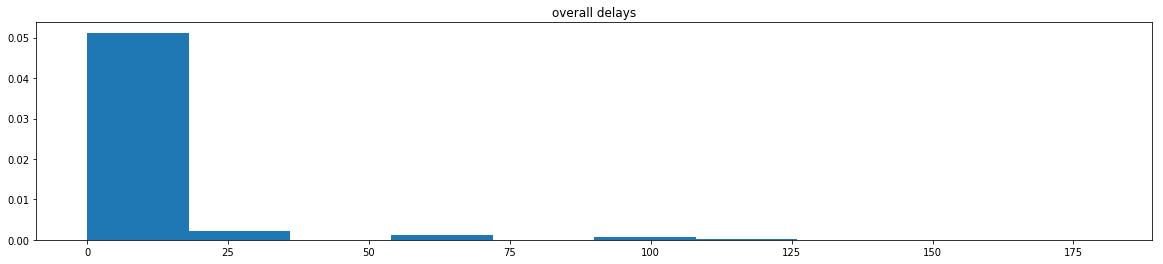

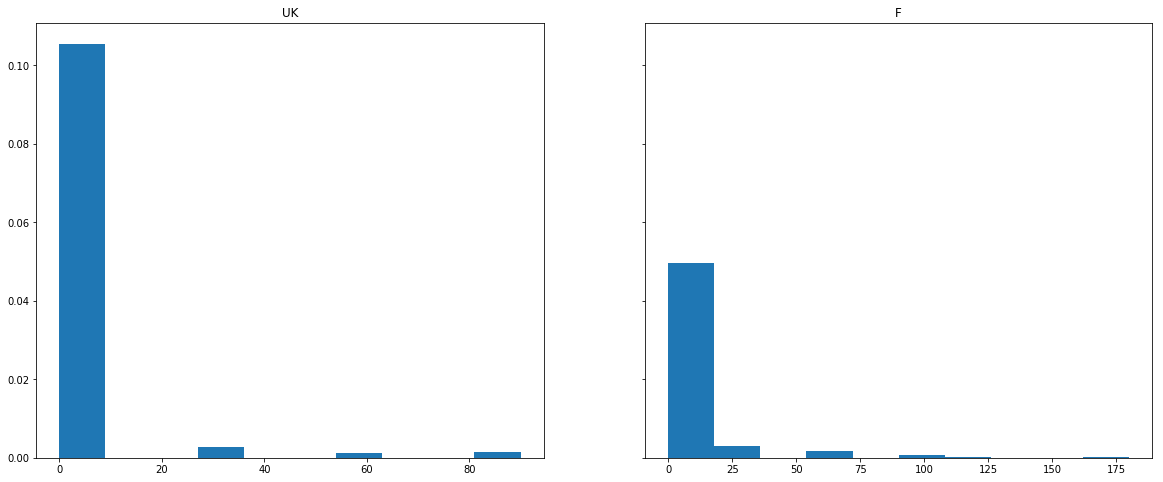

In [179]:
delays    = df['waitingtimeminutes']
delays_UK = df[df['terminal']=='UK']['waitingtimeminutes']
delays_FR = df[df['terminal']=='F']['waitingtimeminutes']

fig, ax = plt.subplots(sharey=True, figsize=(20,4))
plot_hist(ax,  delays,    bins=10, title="overall delays")

fig, (ax_uk, ax_fr) = plt.subplots(1, 2, sharey=True, figsize=(20,8))
plot_hist(ax_uk, delays_UK, bins=10, title="UK")
plot_hist(ax_fr, delays_FR, bins=10, title="F")

##### Apparently there is not much delays, the frech side has more delays and longer ones. Check a bit just in case

In [153]:
cntuk = len(delays_UK[delays_UK==0])
cntfr = len(delays_FR[delays_FR==0])
cnt   = len(delays[delays==0])

_df = pd.DataFrame(data={'all':[cnt], 'UK':[cntuk], 'FR':[cntfr]})
_df

,FR,UK,all
0,3803,4045,7848


##### All seems in order, data is consistent

### Lets figure a Hipotesis: "delays are dependent on some TIME factors like day of week" and of course, the tunnel end

In [285]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
import datetime

df['dow'] = df.apply(lambda row: datetime.datetime.strptime(row['retrievaldate'][0:19], '%Y-%m-%d %H:%M:%S').weekday(), axis=1)
df['idterminal'] = df.apply(lambda row: 1 if row['terminal']=='UK' else 2, axis=1)

In [218]:
df.head()

,terminal,servicetype,departures,waitingtimeminutes,journeytimeminutes,delayreason,retrievaldate,latitude,longitude,trend,dow,idterminal
0,UK,normal,6,0,60,none/unknown,2018-02-01 00:13:06.432,51.0963,1.13505,stable,3,1
1,F,normal,4,0,60,none/unknown,2018-02-01 00:13:06.57,50.9239,1.81604,stable,3,2
2,UK,normal,6,0,60,none/unknown,2018-02-01 00:42:53.941,51.0963,1.13505,stable,3,1
3,F,normal,5,0,60,none/unknown,2018-02-01 00:42:54.08,50.9239,1.81604,stable,3,2
4,UK,normal,4,0,60,none/unknown,2018-02-01 01:12:54.094,51.0963,1.13505,stable,3,1


In [320]:
df_UK = df[df['terminal']=='UK']
df_FR = df[df['terminal']=='F']

reg = np.array([df['idterminal'], df['dow'], df['waitingtimeminutes']]).transpose()
reg_UK = np.array([df_UK['idterminal'], df_UK['dow'], df_UK['waitingtimeminutes']]).transpose()
reg_FR = np.array([df_FR['idterminal'], df_FR['dow'], df_FR['waitingtimeminutes']]).transpose()

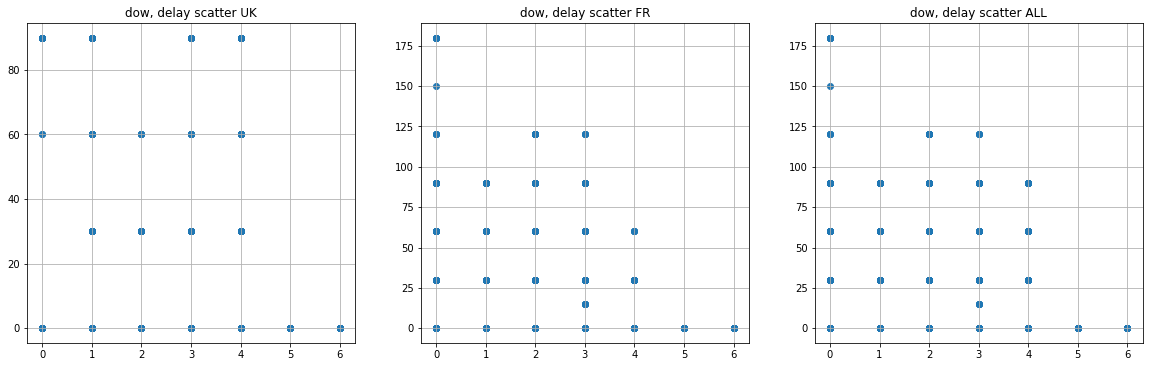

In [346]:
plt.subplots(1, 3, sharey=True, figsize=(20,20))

plt.subplot(331)
plt.scatter(reg_UK[:,1], reg_UK[:,2])
plt.grid()
plt.title("dow, delay scatter UK")

plt.subplot(332)
plt.scatter(reg_FR[:,1], reg_FR[:,2])
plt.grid()
plt.title("dow, delay scatter FR")

plt.subplot(333)
plt.scatter(reg[:,1], reg[:,2])
plt.grid()
plt.title("dow, delay scatter ALL")

km = KMeans(n_clusters=21).fit(reg)
labels = km.labels_


#### THE HIPOTESIS IS TRUE, THE DAY OF WEEK HAS SOMETHING TO DO WITH DELAYS, FOR EXAMPLE, FRANCE HAS A LOT OF DELAYS ON SUNDAY

### LETS DO THE SAME WITH THE NUMBER OF DEPARTURES - MAYBE HAS SOMETHING TO DO

In [342]:
reg_d = np.array([df['idterminal'], df['departures'], df['waitingtimeminutes']]).transpose()
reg_UK_d = np.array([df_UK['idterminal'], df_UK['departures'], df_UK['waitingtimeminutes']]).transpose()
reg_FR_d = np.array([df_FR['idterminal'], df_FR['departures'], df_FR['waitingtimeminutes']]).transpose()

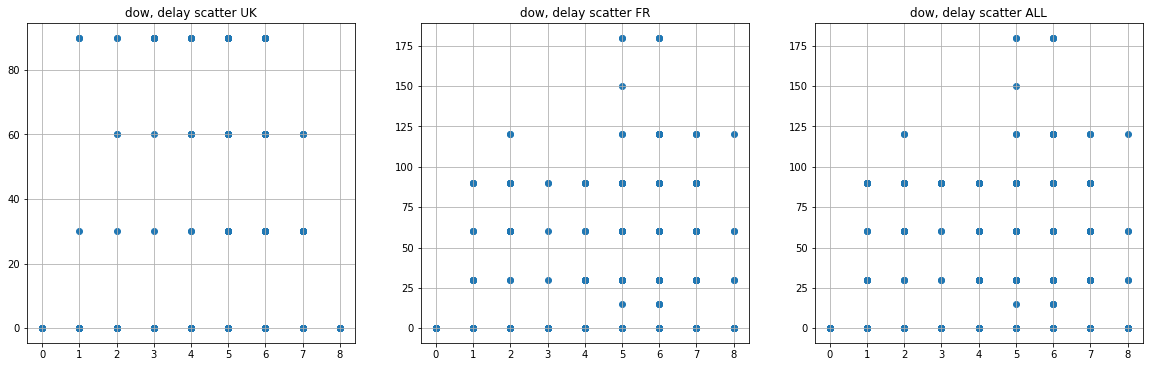

In [345]:
plt.subplots(1, 3, sharey=True, figsize=(20,20))

plt.subplot(331)
plt.scatter(reg_UK_d[:,1], reg_UK[:,2])
plt.grid()
plt.title("dow, delay scatter UK")

plt.subplot(332)
plt.scatter(reg_FR_d[:,1], reg_FR[:,2])
plt.grid()
plt.title("dow, delay scatter FR")

plt.subplot(333)
plt.scatter(reg_d[:,1], reg[:,2])
plt.grid()
plt.title("dow, delay scatter ALL")

km = KMeans(n_clusters=21).fit(reg)
labels = km.labels_



In [286]:
db = DBSCAN(eps=0.3, min_samples=10).fit(reg)

In [292]:
labels = db.labels_
n_clusters_ = np.max(db.labels_) + 1

In [293]:
n_clusters_

36

In [316]:
reg[1,:]

array([2, 3, 0])

In [310]:
km

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=21, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)